# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

# Cashflows

## Import Packages

In [2]:
import pandas as pd
from interesting.interest import CompoundInterestRate
from interesting.portfolio import Portfolio

## Build a Cashflow

In [3]:

from interesting.bonds import NTNB, NominalBond, RealBond

database = pd.read_csv('../src/data/br/fakebonds.csv')

real_pf = Portfolio()
nominal_pf = Portfolio()
ntnb_pf = Portfolio()
inflation = CompoundInterestRate(value=0.040, freq="Y")

for i in range(database.shape[0]):

    initial_capital_pmt = -float(database.iloc[i]['initial_value'].replace(",",""))
    start_date = pd.to_datetime(database.iloc[i]['start_date'])
    end_date = pd.to_datetime(database.iloc[i]['end_date'])
    name=database.iloc[i]['issuer']
    species=database.iloc[i]['species']
    issuer=database.iloc[i]['issuer']
    interest = CompoundInterestRate(value=float(database.iloc[i]['nominal_rate'].replace("%",""))/100, freq="Y")
    freq = database.iloc[i]['freq']
    index_name = database.iloc[i]['index_name']

    if species=="ntnb":
        ntnb_bond = NTNB(start_date=start_date, end_date=end_date, interest=interest, inflation=inflation, initial_capital_pmt=initial_capital_pmt)
        ntnb_pf = ntnb_pf.add_bond(ntnb_bond)
    elif index_name!="ipca":
        nominal_bond = NominalBond(name=name, species=species, issuer=issuer, freq=freq, start_date=start_date, end_date=end_date, interest=interest, initial_capital_pmt=initial_capital_pmt)
        nominal_pf = nominal_pf.add_bond(nominal_bond)
    else:
        real_bond = RealBond(name=name, species=species, issuer=issuer, freq=freq, start_date=start_date, end_date=end_date, interest=interest, initial_capital_pmt=initial_capital_pmt, inflation=inflation, index_name="ipca")
        real_pf = real_pf.add_bond(real_bond)

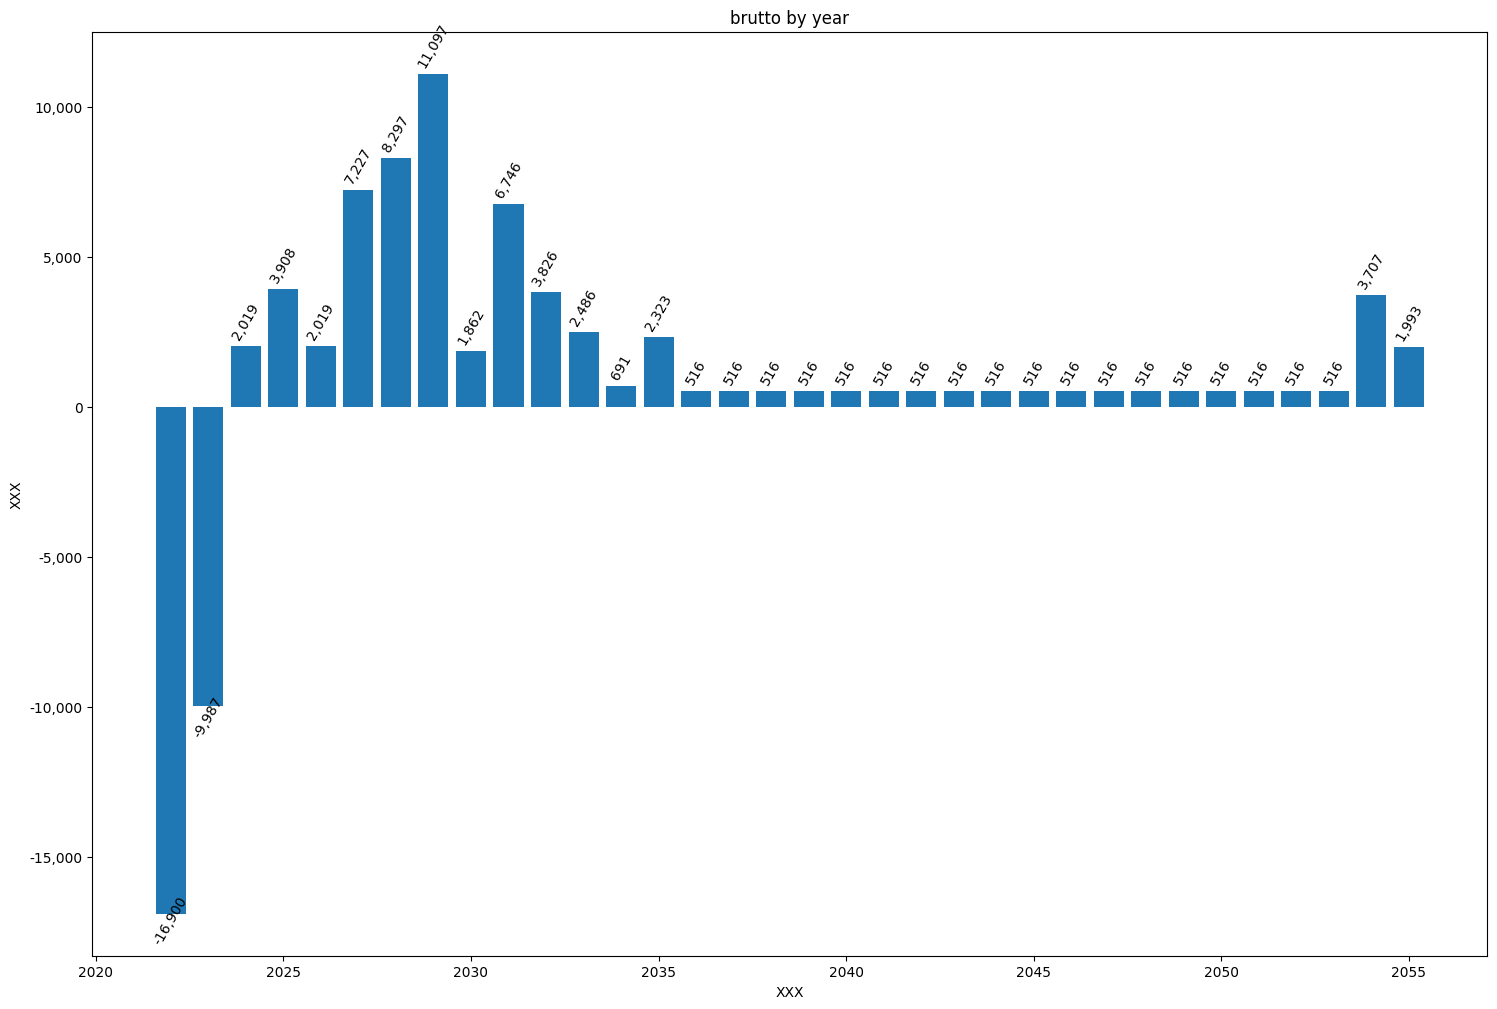

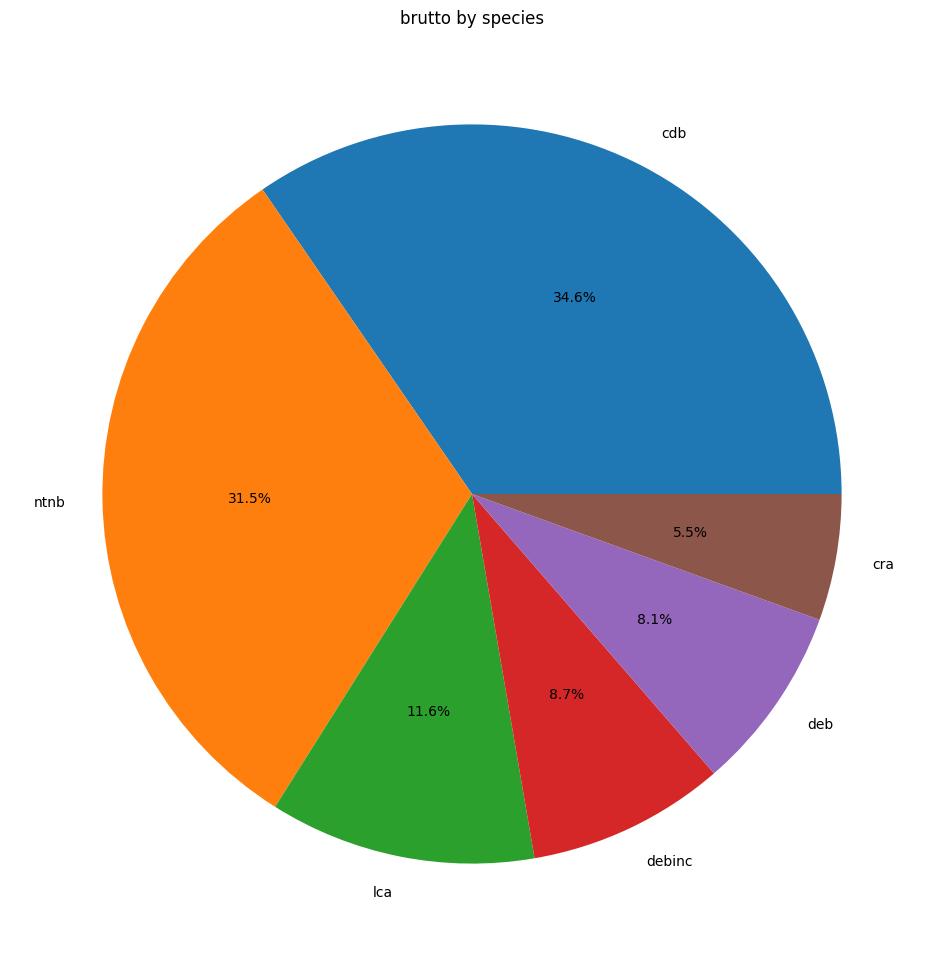

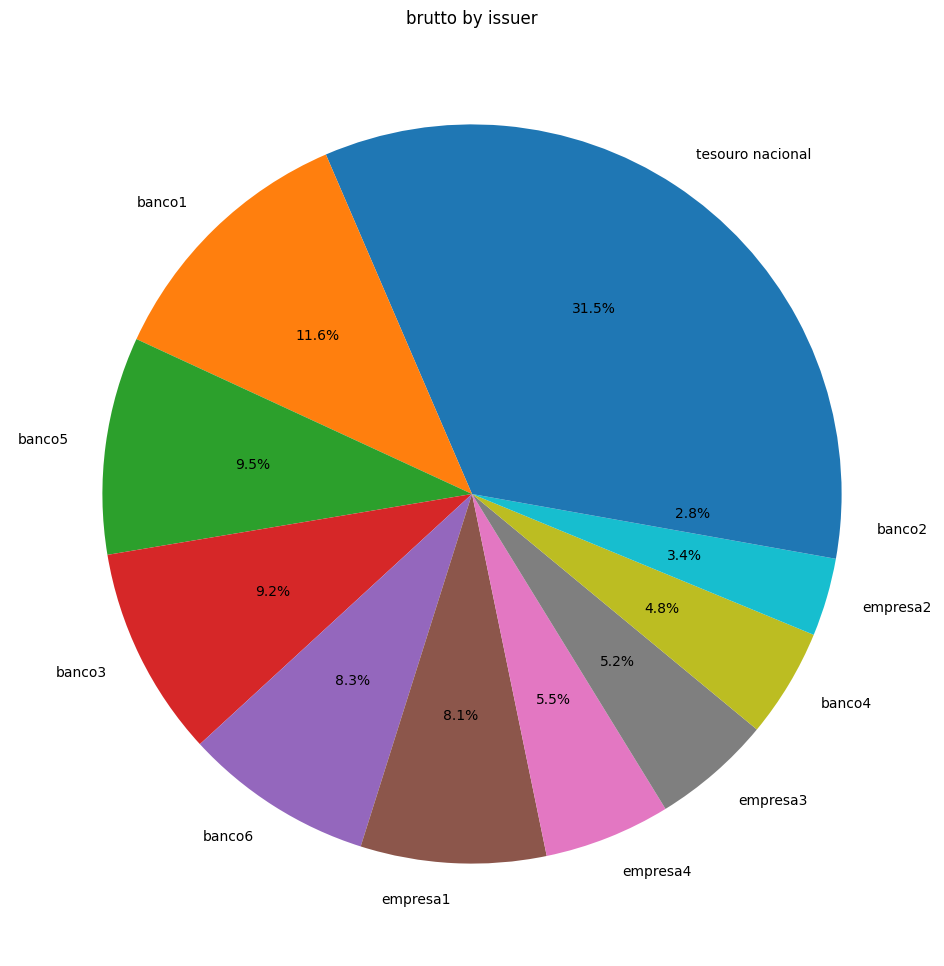

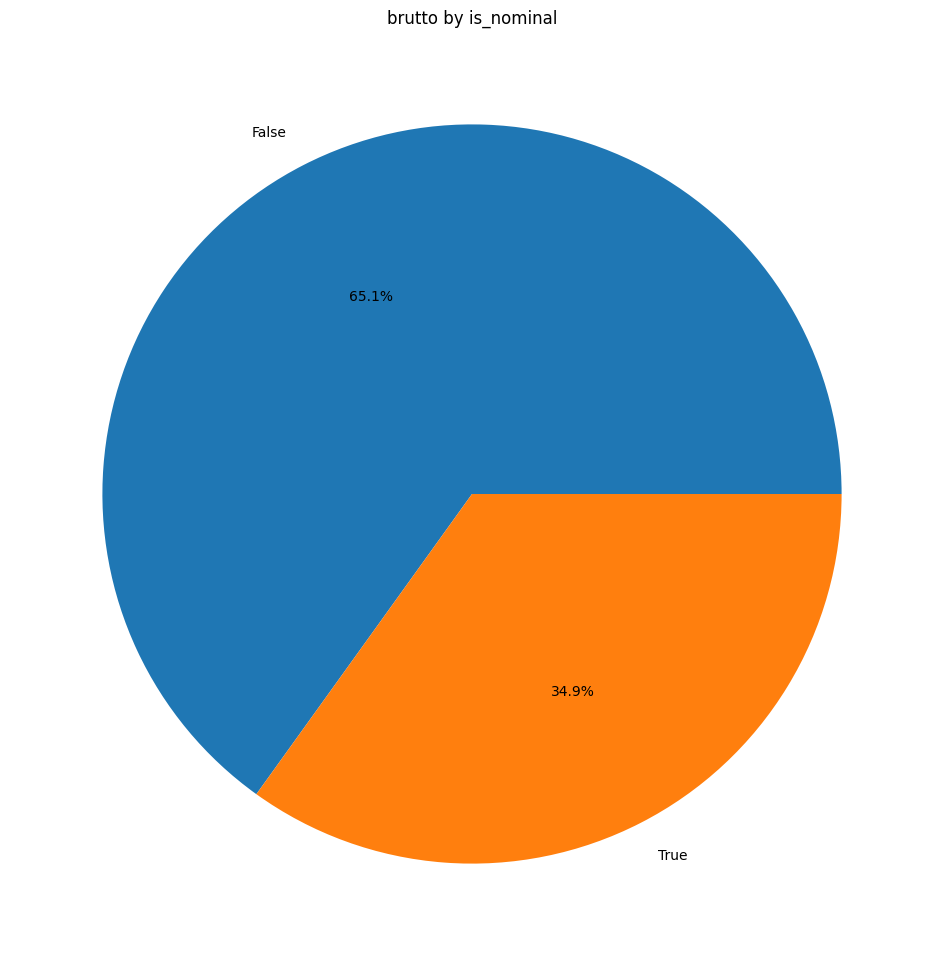

In [4]:
portfolio = real_pf + nominal_pf + ntnb_pf

target = "brutto"
portfolio.plot_target_by_property(target=target, property="year", graph="bar")
portfolio.plot_target_by_property(target=target, property="species", graph="pie")
portfolio.plot_target_by_property(target=target, property="issuer", graph="pie")
portfolio.plot_target_by_property(target=target, property="is_nominal", graph="pie")

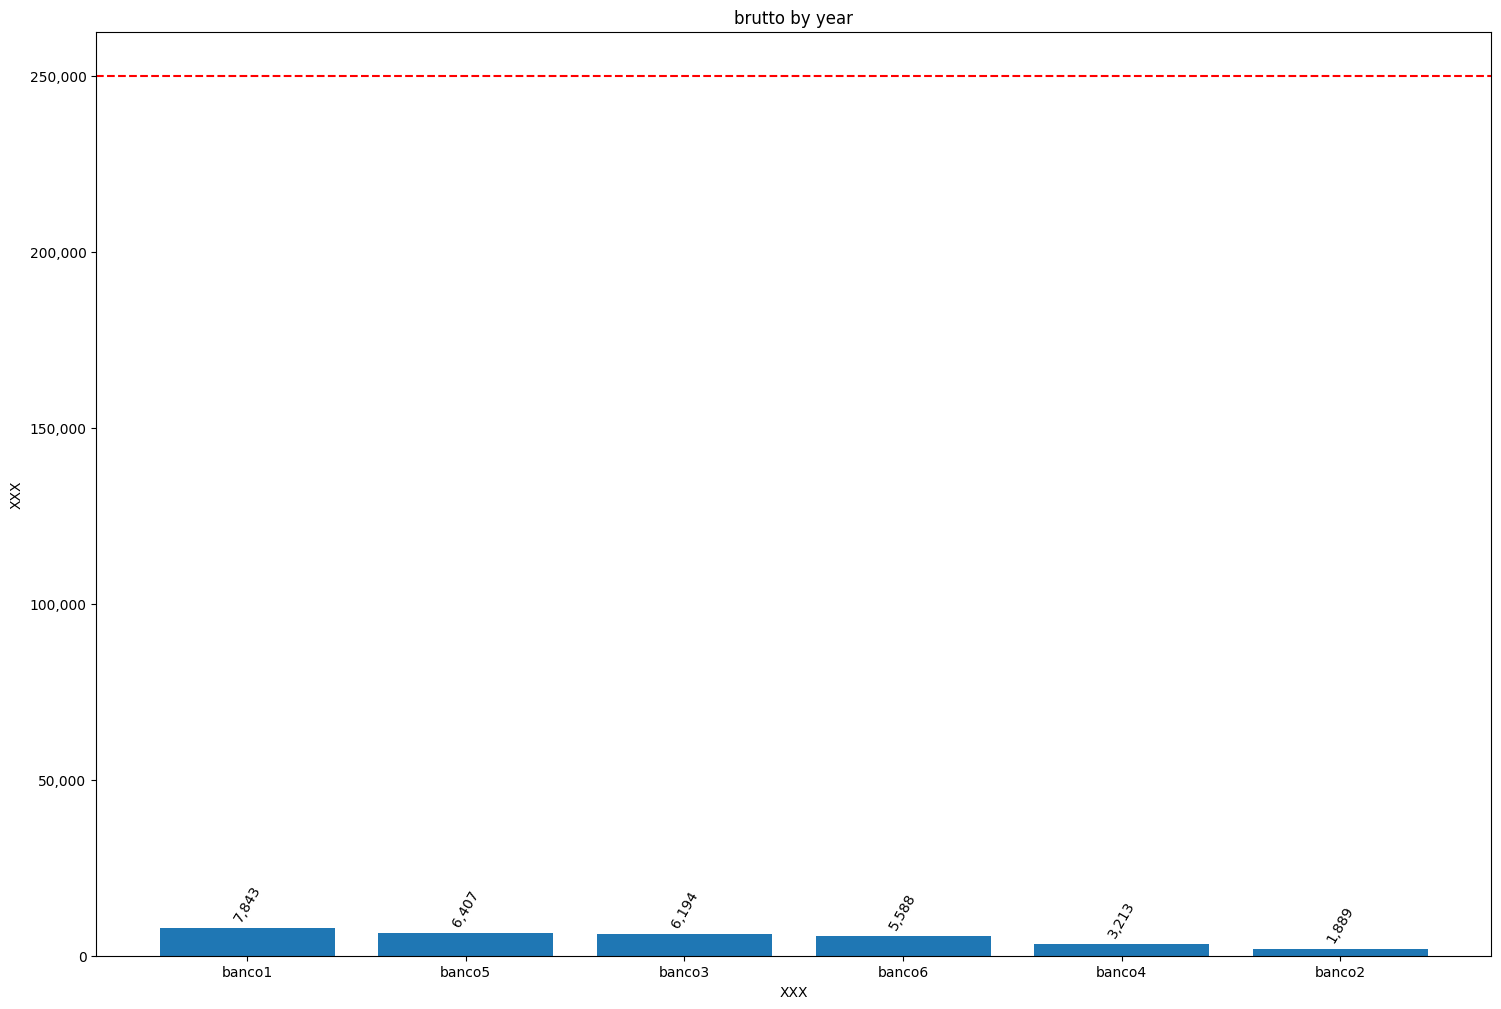

In [5]:
portfolio.plot_fgc_risk(target="brutto")

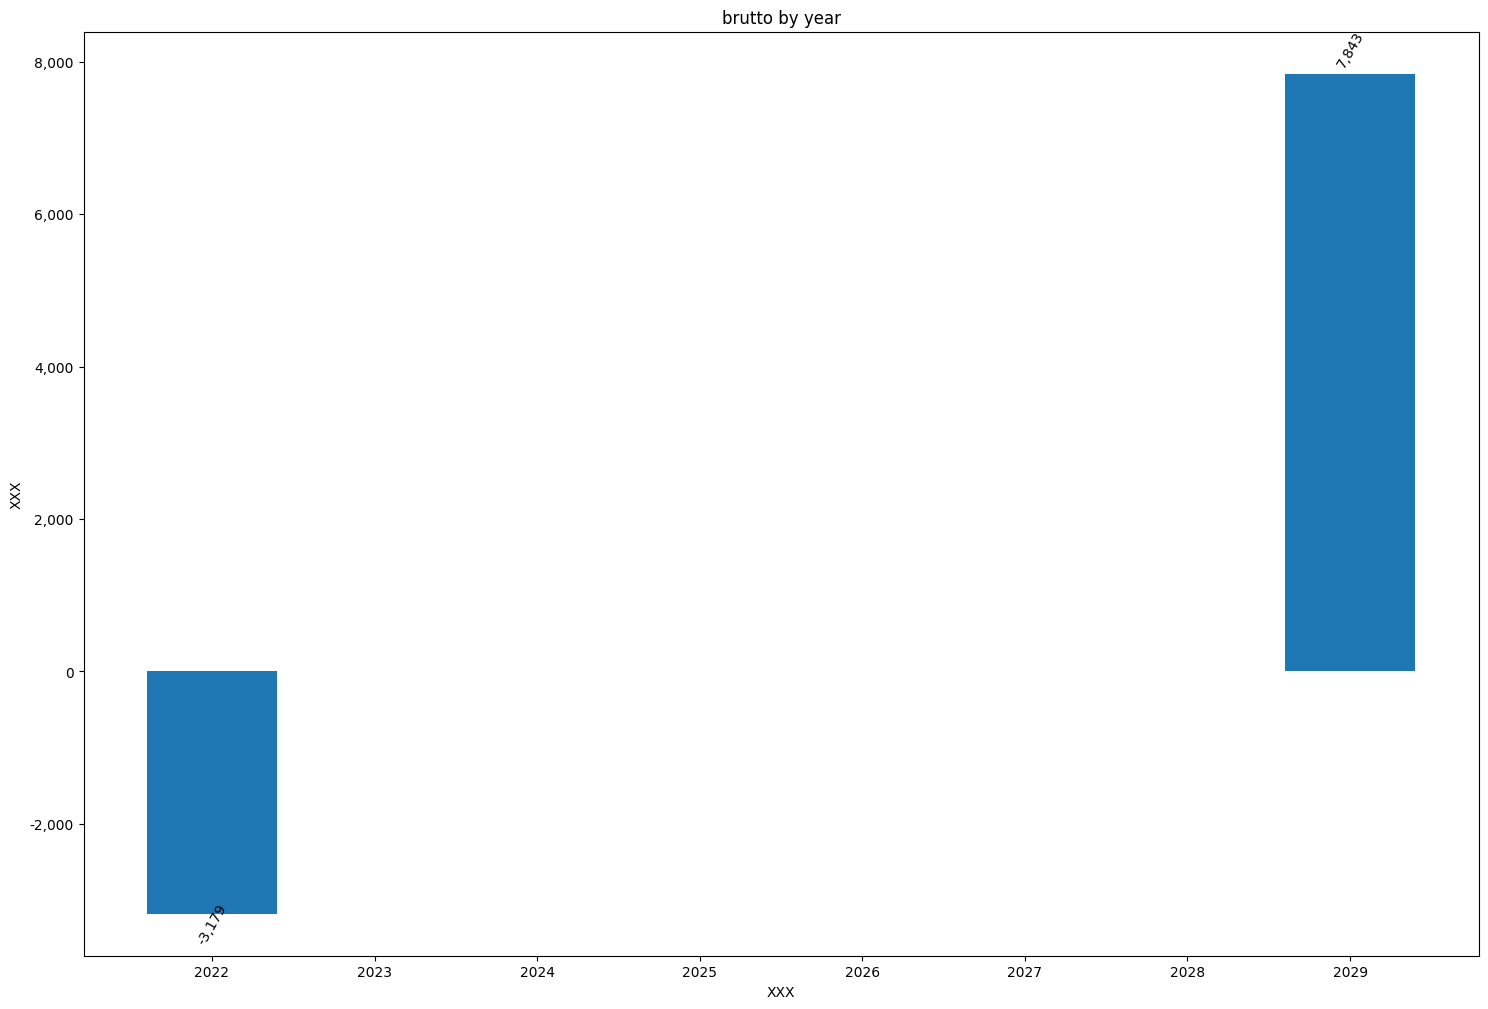

In [6]:
portfolio.plot_issuer_by_year(target="brutto", issuer="banco1")

In [7]:
total_df = portfolio.total_cashflow.data
total_df["year"]=total_df.index.year
total_df = total_df.groupby(["year"]).sum()
total_df

,principal,brutto,interest_paid
year,,,
2022,-17024.39,-16900.085969,124.304031
2023,-11252.19,-9987.492014,1264.697986
2024,0.00,2019.370706,2019.370706
2025,1562.27,3908.328908,2346.058908
2026,0.00,2019.370706,2019.370706
2027,2762.64,7227.120193,4464.480193
2028,3351.44,8297.357309,4945.917309
2029,4491.21,11096.507829,6605.297829
2030,0.00,1862.243225,1862.243225


# Reinvestment

In [8]:
import matplotlib.pyplot as plt


def plot_bars(data, target="brutto"):
    categories = data.index
    values = data[target].cumsum()

    fig, ax = plt.subplots(figsize=(18, 12))
    plt.bar(categories, values)

    for c, v in zip(categories, values):
        text = f'{v:,.0f}'
        plt.text(c, v + 0.5, text, ha='center', rotation = 45)
        
    plt.show()

In [9]:
import numpy as np

data = total_df[total_df.index>2024]

matrix_size = len(data.brutto)

matrix = np.zeros((matrix_size, matrix_size))

for col_idx in range(matrix_size):
    for row_idx in range(matrix_size):
        if row_idx > col_idx:
            matrix[row_idx, col_idx] = row_idx - col_idx
        else:
            matrix[row_idx, col_idx] = 0

matrix = (1.08)**matrix

for col_idx in range(matrix_size):
    for row_idx in range(matrix_size):
        if row_idx < col_idx:
            matrix[row_idx, col_idx] = 0

matrix

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.08      ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.1664    ,  1.08      ,  1.        ,  0.        ,  0.        ,
       

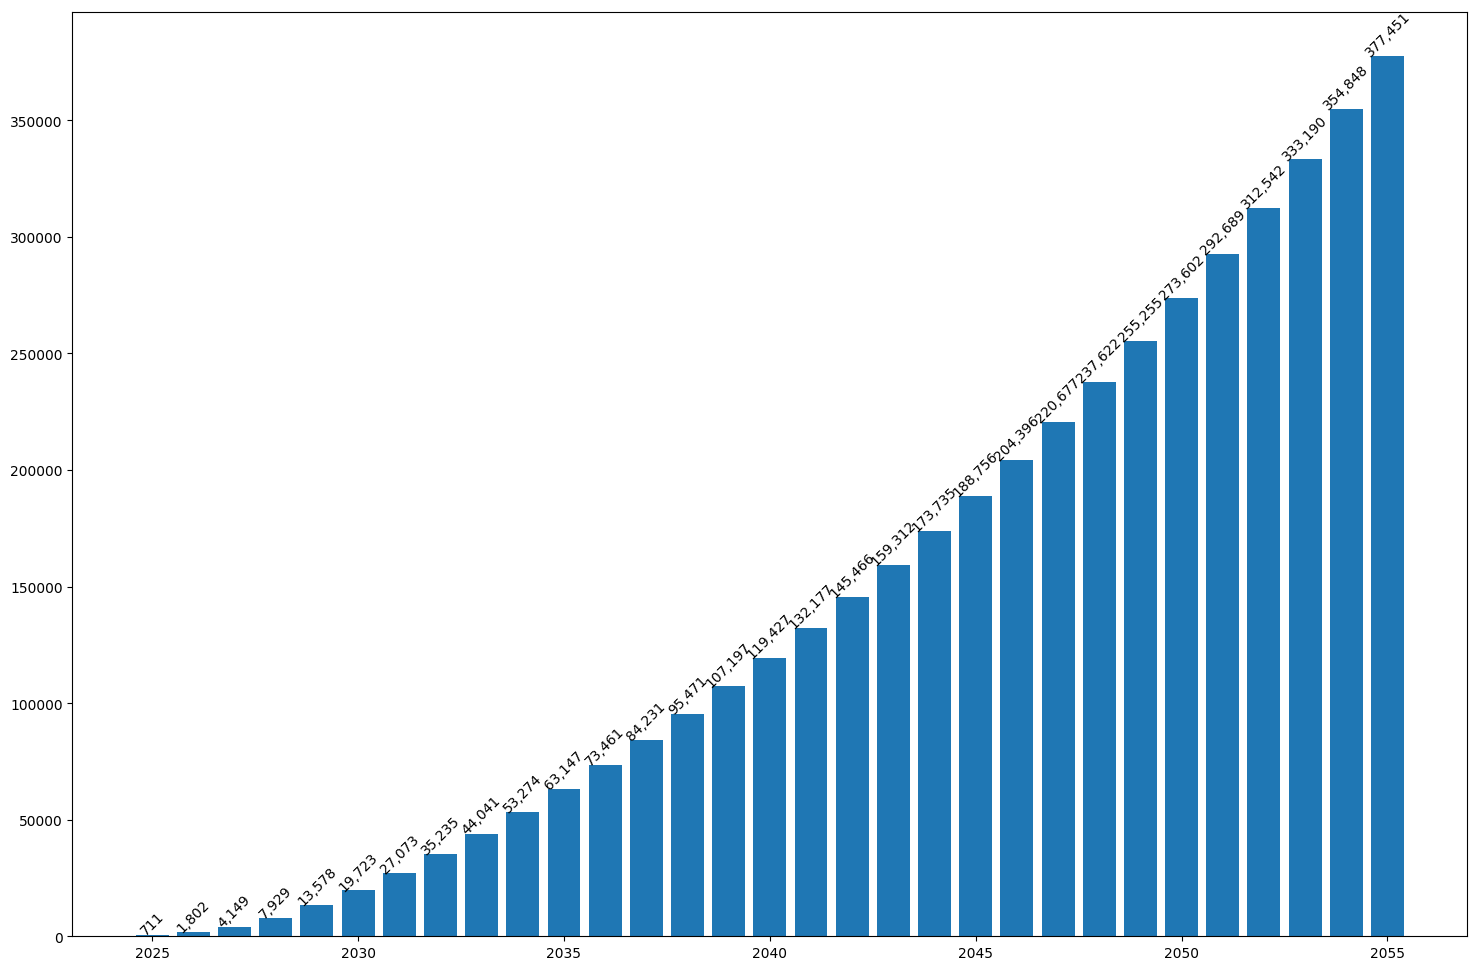

In [10]:
portfolio_brutto_value = pd.DataFrame(data.brutto.values * matrix).sum(axis=1).values
total_reinvested_df = pd.DataFrame(portfolio_brutto_value)
total_reinvested_df.index=data.index
total_reinvested_df.columns=["brutto"]
total_reinvested_df["deflator"] = [1.04**(i) for i in range(len(total_reinvested_df))]
total_reinvested_df["brutto_deflated"] = total_reinvested_df["brutto"]/total_reinvested_df["deflator"]
total_reinvested_df["brutto_deflated"] = total_reinvested_df["brutto"]/total_reinvested_df["deflator"]
total_reinvested_df["brutto_deflated_euro"] = total_reinvested_df["brutto_deflated"]/5.5

plot_bars(total_reinvested_df, target="brutto_deflated_euro")

<Axes: xlabel='year'>

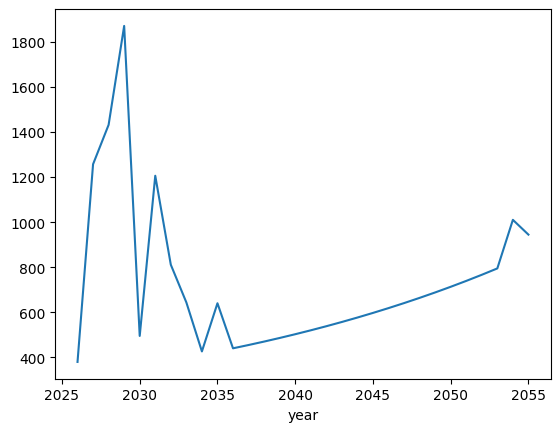

In [11]:
total_reinvested_df["brutto_deflated_euro"].diff().plot()